# Guided mode expansion: W1 waveguide optimization with Autograd

We use `legume` to optimize a PhC slab with a W1 waveguide, i.e., a missing row of holes in the triangular lattice. And we take advantage of the presence of a vertical ($kz$) mirror plane.

It is similar to the example 05, but
* it is done in a PhC slab, using gme instad of pwe
* it is a triangular lattice of holes (not pillars), the PBG is for $xy$-even (TE-like) modes
* the W1 waveguide supports modes with two parities with respect to $kz$ mirror symmetry, and we must use symmetry separation to disentangle the modes.

For a treatment of the W1 waveguide in PhC slab with kz-symmetry separation, see e.g. Ch. 8 of [Molding the Flow of Light](http://ab-initio.mit.edu/book/) and [Opt. Expr. 13, 4939 (2005)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-13-13-4939&id=84559).

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume import GuidedModeExp, Circle, ShapesLayer
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define W1 waveguide with a supercell

In [39]:
# PhC parameters
D = 0.5      # slab thickness
ra = 0.25     # pillar radius
eps_b = 12   # background permittivity
eps_c = 1    # hole permittivity (air)
eps_lower, eps_upper = 1, 1  # cladding permittivities

# supercell parameters
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the holes will be modified
Nx = 5       # Supercell size in the x-direction
if (Ny%2 != 0): raise ValueError('number of rows Ny must be even')
if (Ny_opt >= Ny/2): raise ValueError('Ny and Ny_opt are not consistent')
Nholes = Nx*(Ny-1)    # total number of holes
Nopt   = Nx*Ny_opt    # number of optimized holes

# Initialize a rectangular lattice
lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])


In [40]:
def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters
    dx, dy, and dr, for the Nx*Ny_opt number of holes that get shifted
    Notice that the structure is symmetric wrt a xz mirror plane:
    the holes for y>0 and y<0 are moved symmetrically.
    This is important in order to disentangle modes with different kz-symmetry
    """

    # we reinitialize the photonic crystal at each step, to be on the safe side
    phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
    phc.add_layer(d=D, eps_b=eps_b)

    # Initialize a layer and the positions of the holes for the regular waveguide
    layer_wg = ShapesLayer(lattice, eps_b=eps_b)

    xc = []; yc = []; rc = []  # initialize variations of hole positions and radii
    jhole, jopt = 0, 0         # these are counters, for later check

    for ih in range(1, Ny//2+1):
        for ix in range(-Nx//2+1, Nx//2+1):
            if (ih <= Ny_opt):                # optimized holes
                xc.append((ih%2)*0.5 + ix  + dx[jopt])
                yc.append( ih*np.sqrt(3)/2 + dy[jopt])
                rc.append(ra+dr[jopt])
                xc.append((ih%2)*0.5 + ix  + dx[jopt]) # this is the hole
                yc.append(-ih*np.sqrt(3)/2 - dy[jopt]) # in the symmetric row
                rc.append(ra+dr[jopt])
                jhole = jhole+2               # two holes, but one set of optimization parameters
                jopt = jopt+1
            else:                             # fixed holes
                xc.append((ih%2)*0.5 + ix)
                yc.append( ih*np.sqrt(3)/2)
                rc.append(ra)
                jhole = jhole+1
                # the upper edge row consists of half-holes, and we do not need to define the lowe one, to avoid double counting
                # the proper definition of the supercell should be checked with the visualization of the dielectric functions
                # (the shapes are not sufficient because they are not sensitive to double counting)
                if (ih != Ny//2):
                  xc.append((ih%2)*0.5 + ix)    # this is the hole
                  yc.append(-ih*np.sqrt(3)/2)   # in the symmetric row
                  rc.append(ra)
                  jhole = jhole+1

    nholes = jhole
    nopt = jopt

    # add the holes to the PhC slab core layer
    for n in range(nholes):
        phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=rc[n], x_cent=xc[n], y_cent=yc[n]))

    return phc, nholes, nopt

We first simulate the starting (un-modified) waveguide, to check the supercell and identify the waveguide modes. Notice that the Brillouin zone is folded Nx times in the $x$-direction. To check the waveguide dispersion without folding, use Nx=1.

Nholes, Nholes_check= 65 65
Nopt, Nopt_check= 15 15
npw =  275


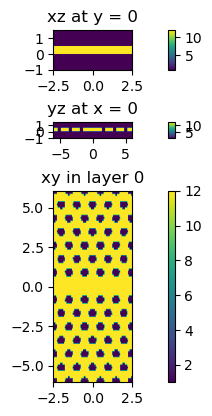

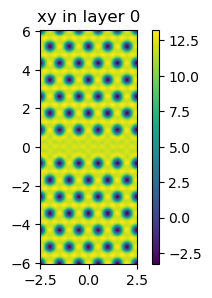

In [41]:
# Initialize shift parameters to zeros
dx0, dy0, dr0 = np.zeros(Nopt), np.zeros(Nopt), np.zeros(Nopt)

# you can use this to initialize with random numbers and check that the supercell remains kz-symmetric
#dx0 = (2*np.random.rand(Nopt)-1)*0.2
#dy0 = (2*np.random.rand(Nopt)-1)*0.2
#dr0 = (2*np.random.rand(Nopt)-1)*0.1
#print(dx0)
#print(dy0)
#print(dr0)

# Initialize the photonic crystal
phc0, Nholes_check, Nopt_check = wg_sc(dx0, dy0, dr0)
print('Nholes, Nholes_check=', Nholes, Nholes_check)
print('Nopt, Nopt_check=', Nopt, Nopt_check)

# visualize the structure with vertical cuts, and in the xy plane with eps_ft method
legume.viz.structure(phc0, xz=True, yz=True, figsize=2, cmap='viridis')

gmax = 1.05 # minimum reasonavle is 1.05 yielding 189 PWs
truncate_g = 'tbt' # for a rectangular cell, 'tbt' truncation is still compatible with symmetry separation and much faster for optimization
gme0 = legume.GuidedModeExp(phc0, gmax=gmax, truncate_g=truncate_g)
npw = np.shape(gme0.gvec)[1]  # number of plane waves in the expansion
print('npw = ', npw)

legume.viz.eps_ft(gme0, Nx=200, Ny=200, figsize=2, cbar=True, cmap='viridis')

In [42]:
# Define a Brillouin zone path in kx and run the GME
nintervals = 50
nk = nintervals +1
path = lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nintervals])

kpoints = path['kpoints']

# we consider only xy-even (sigma_xy=+1 or TE-like) modes: this is the only polarization yielding a photonic band gap
# and we need quite a number of eigenvalues because of the supercell
gmode_inds = [0]
numeig = 100

gme0.run(kpoints=path['kpoints'], gmode_inds=gmode_inds, numeig=numeig, verbose=True, compute_im=False)

freqs = gme0.freqs
nfreq = np.shape(freqs)[1]
print(freqs.shape)

Running gme k-points: │█-----------------------------│ 2 of 51

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 275 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'        │ 2.467    │ │██████████----------│   50% │
│ Inverse matrix of Fourier-space permittivity               │ 0.003    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver            │ 0.764    │ │███-----------------│   16% │
│ Creating GME matrix                                        │ 1.660    │ │██████--------------│   34% │
├────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 51 k-points    │ 4.914    │ │████████████████████│  100% │
└────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

(51, 100)


Text(0, 0.5, 'Frequency')

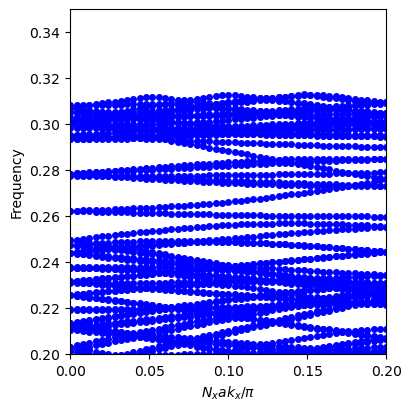

In [43]:
# Plot the (folded) waveguide bands
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(4, 4))
ax.plot(kpoints[0, :]/np.pi, freqs, 'bo', markersize=4)
ax.set_ylim([0.2, 0.35])
ax.set_xlim([0, kpoints[0, -1]/np.pi])
ax.set_xlabel('$N_xa k_x/ \pi$')
ax.set_ylabel('Frequency')

Frankly speaking, it is a mess, since there are two folded waveguide modes in the photonic bandgap. But we can simplify the band structure by taking advantage of symmetry with respect to the $xz$ mirror plane, then only one line-defect mode remains.

In [44]:
kz_symmetry = 'odd'

# Define a BZ path in kx and run the GME
# we reduce the number of k-points, to reduce the computing time later
nintervals = 20
nk = nintervals +1
path = lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nintervals])

kpoints = path['kpoints']
#print(kpoints)

# change of basis for symmetrization can be done with dense or sparse matrices
# in this example with a low number of plane waves they are almost equivalent
# sparse matrices have a more favourable scaling with the number of plane waves
# symmetrization + sparse matrices + autograd is the newest feature of the code, still in beta-testing
use_sparse = True

# we consider only xy-even (TE-like) modes: this is the only polarization yielding a photonic band gap
gmode_inds, numeig = [0], 50

gme0 = legume.GuidedModeExp(phc0, gmax=gmax, truncate_g=truncate_g)
gme0.run(kpoints=path['kpoints'],
        gmode_inds=gmode_inds,
        numeig=numeig,
        verbose=True,
        compute_im=False,
        eig_sigma = 0.0,
        use_sparse=use_sparse,
        kz_symmetry=kz_symmetry, angles=path['angles']
        )

freqs = gme0.freqs
nfreq = np.shape(freqs)[1]
print(freqs.shape)

Running gme k-points: │██----------------------------│ 2 of 21

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 275 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'        │ 0.990    │ │███████████---------│   56% │
│ Inverse matrix of Fourier-space permittivity               │ 0.003    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver            │ 0.059    │ │--------------------│    3% │
│ Creating GME matrix                                        │ 0.579    │ │██████--------------│   33% │
│ Creating change of basis matrix using sparse matrices      │ 0.136    │ │█-------------------│    8% │
├────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 21 k-points    │ 1.774    │ │████████████████████│  100% │
└────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

(21, 50)


Text(0, 0.5, 'Frequency')

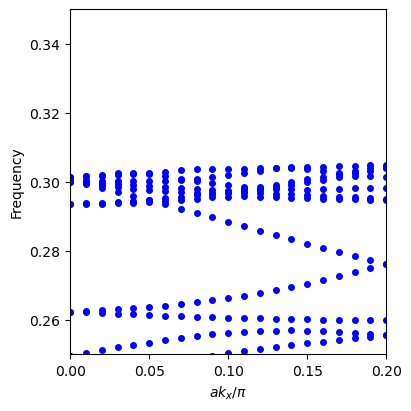

In [45]:
# Plot the (folded) waveguide bands
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(4, 4))
ax.plot(kpoints[0, :]/np.pi, freqs, 'bo', markersize=4)
ax.set_ylim([0.25, 0.35])
ax.set_xlim([0, kpoints[0, -1]/np.pi])
ax.set_xlabel('$a k_x/ \pi$')
ax.set_ylabel('Frequency')

## Compute gradients

We can use `legume` and `autograd` to efficiently compute gradients of GME simulations. We will define the objective function as the mean-squared error between one of the waveguided bands and a target band shape. Let's first illustrate this target.

[(28, 0.28427685643472334), (29, 0.2862026541454552), (30, 0.29046895276485823), (31, 0.2910828821429794), (32, 0.2942365417795169), (33, 0.29692388809129944), (34, 0.299161232531723), (35, 0.30115030074719545), (36, 0.30231477373517307), (37, 0.3075721652362373), (38, 0.3093551831886929)]


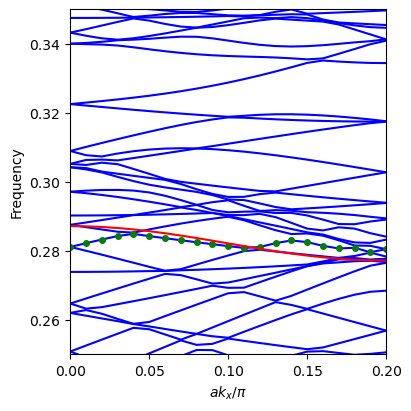

In [28]:
# Define a target band shape and which band we will try to optimize
kpoints = path['kpoints'][0, :]

#f_target = -0.01*np.cos(kpts*Nx) # Just a cosine target
f_target = 0.005*np.cos(kpoints*Nx) # Just a cosine target

# we pick up the inde of the line-defect band to be optimized
jk = 5
result = [(j, freqs[jk,j]) for j in range(nfreq) if ((freqs[jk,j] > 0.28) and (freqs[jk,j] < 0.31)) ]
print(result)
(b_target, frequency) = result[0]

#
#b_target = Nx*Ny - 3             # Index of the middle waveguide band in the folded structure

# Plot the folded waveguide bands and the target shape centered at the target band
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(4, 4))
ax.plot(kpoints/np.pi, gme0.freqs, 'b')
ax.plot(kpoints/np.pi, gme0.freqs[:, b_target], 'go', markersize=4)
ax.plot(kpoints/np.pi, f_target + np.mean(gme0.freqs[:, b_target]), 'r')
ax.set_ylim([0.25, 0.35])
ax.set_xlim([0, kpoints[-1]/np.pi])
ax.set_xlabel('$a k_x/ \pi$')
ax.set_ylabel('Frequency');

In [10]:
# Define the objective function for the target band shape
def of_sc(params):
    # Define shift parameters
    dx = params[0:Nopt]
    dy = params[Nopt:2*Nopt]
    dr = params[2*Nopt:]

    # Initialize and run the plane-wave expansion
    phc, Nholes_check, Nopt_check = wg_sc(dx, dy, dr)

    gme = legume.GuidedModeExp(phc, gmax=gmax, truncate_g=truncate_g)
    gme.run(kpoints=path['kpoints'],
        gmode_inds=gmode_inds,
        numeig=numeig,
        verbose=False,
        compute_im=False,
        use_sparse=use_sparse,
        kz_symmetry=kz_symmetry, angles=path['angles']
        )

    # Get the target band, ans shift by its mean value
    band = gme.freqs[:, b_target]
    b_shift = band - npa.mean(band)

    # this is a counter, to know the number of function evaluations in the optimization
    try:
      of_sc.counter = of_sc.counter + 1
    except:
      goofy = 0

    # Return the MSE between the shifted band and the target
    return npa.sum(npa.square(b_shift - f_target))

We test the gradient computation. Note that `legume` (through `autograd`) computes the gradients efficiently, using one backpropagation to get the derivative of the objective w.r.t. *every* parameter simultaneously. Because of time considerations, for the numerical finite-difference check we will only pick one parameter at random. Also note that we initialize the parameters with some random small values, in order to break the high symmetry of the un-modified structure.

In [11]:
# To compute gradients, we need to set the `legume` backend to 'autograd'
legume.set_backend('autograd')

kz_symmetry = 'odd'

# Initialize random starting parameters to break the high symmetry
#dx0 = 0.01*np.random.randn(Nopt)
#dy0 = 0.01*np.random.randn(Nopt)
#dr0 = 0.01*np.random.randn(Nopt)
#pstart = np.hstack((dx0, dy0, dr0))
pstart = 0.01*np.random.randn(3*Nopt)

# Choose one parameter index at random for the numerical check
# We pick one of the dy-s because they have the largest gradient in the beginning
ind0 = np.random.randint(Nopt, 2*Nopt, 1)

# Compute the autograd gradients (NB: all at once!)
t = time.time()
grad_a = grad(of_sc)(pstart)
# Print the gradient w.r.t. the parameter index ind0
print("Autograd gradient:  %1.6f, computed in %1.4fs" %(grad_a[ind0], time.time() - t))




# Compute a numerical gradient for parameter ind0
t = time.time()
p_test = np.copy(pstart)
p_test[ind0] = p_test[ind0] + 1e-5
grad_n = (of_sc(p_test) - of_sc(pstart))/1e-5
print("Numerical gradient: %1.6f, computed in %1.4fs" %(grad_n, time.time() - t))

print("Relative difference: %1.2e" %np.abs((grad_a[ind0] - grad_n)/grad_n))

/tmp/ipykernel_331403/3005122448.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Autograd gradient:  %1.6f, computed in %1.4fs" %(grad_a[ind0], time.time() - t))


Autograd gradient:  0.000035, computed in 48.3556s
Numerical gradient: 0.000035, computed in 4.9786s
Relative difference: 5.78e-04


/tmp/ipykernel_331403/3005122448.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Relative difference: %1.2e" %np.abs((grad_a[ind0] - grad_n)/grad_n))


The two gradients match very well, and the `autograd` simulation takes *all* the derivatives at once.

## Optimize the waveguide

For the optimization, we will use the `Minimize` class provided with `legume`, which implements either `adam` or `lbfgs` minimization. The `lbfgs` minimizer is just a wrapper around the `SciPy` implementation, and any external optimization function can also be combined with the gradient computation from `legume`. Note that `autograd` provides both a `grad` function as used above, and an `obj_and_grad` function that returns simultaneously the value and the gradient of the objective function, which can be useful for custom optimization functions.

In [12]:
# Initialize an optimization object
opt = Minimize(of_sc)

# Run the optimization

t0 = time.time()
of_sc.counter = 0
# (p_opt, ofs1) = opt.lbfgs(pstart, Nepochs=15, bounds = [-0.15, 0.15])
(p_opt, ofs1) = opt.adam(pstart, Nepochs=15)
print('number of function evaluations, computing time = ', of_sc.counter, time.time()-t0)

Epoch:    1/  15 | Duration:  61.41 secs | Objective: 1.724694e-04
Epoch:    2/  15 | Duration: 109.19 secs | Objective: 4.978757e-05
Epoch:    3/  15 | Duration:  50.45 secs | Objective: 4.491480e-05
Epoch:    4/  15 | Duration:  25.25 secs | Objective: 4.317438e-05
Epoch:    5/  15 | Duration:  25.39 secs | Objective: 4.108641e-05
Epoch:    6/  15 | Duration:  26.13 secs | Objective: 3.785686e-05
Epoch:    7/  15 | Duration:  26.06 secs | Objective: 3.126115e-05
Epoch:    8/  15 | Duration:  25.47 secs | Objective: 1.041440e-05
Epoch:    9/  15 | Duration:  24.99 secs | Objective: 6.151371e-06
Epoch:   10/  15 | Duration:  24.70 secs | Objective: 3.995997e-06
Epoch:   11/  15 | Duration:  26.59 secs | Objective: 1.842387e-06
Epoch:   12/  15 | Duration:  25.68 secs | Objective: 1.306757e-06
Epoch:   13/  15 | Duration:  25.45 secs | Objective: 6.321808e-07
Epoch:   14/  15 | Duration:  24.33 secs | Objective: 1.786523e-07
Epoch:   15/  15 | Duration:  52.48 secs | Objective: 1.342704

Finally let's plot the optimized band, and the underlying structure.
It is important to check that there are no overlaps of the holes (they may still occur during the optimization, this is difficult to control, but it is most important that no overlaps occur in the final structure).

In [13]:
# Get the shifts from the optimized parameters
dx = p_opt[0:Nopt]
dy = p_opt[Nopt:2*Nopt]
dr = p_opt[2*Nopt:]

# Initialize and run the PWE with the optimized shifts
phc, Nholes_check, Nopt_check = wg_sc(dx, dy, dr)
gme = legume.GuidedModeExp(phc, gmax=gmax, truncate_g=truncate_g)
gme.run(kpoints=path['kpoints'],
        gmode_inds=gmode_inds,
        numeig=numeig,
        verbose=False,
        compute_im=False,
        kz_symmetry=kz_symmetry, angles=path['angles']
        )

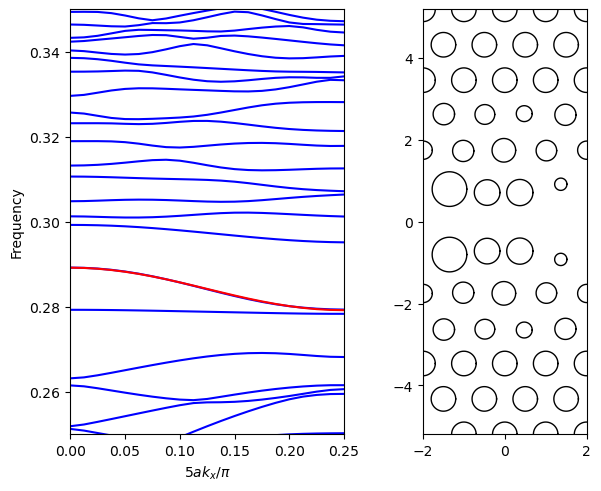

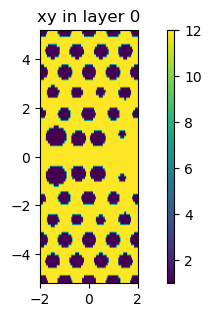

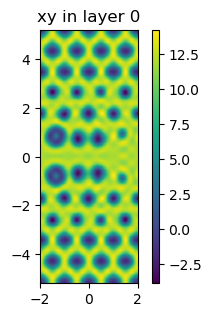

In [14]:
# Plot the waveguide bands and the target band
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].plot(gme.kpoints[0, :]/np.pi, gme.freqs, 'b')
ax[0].plot(gme.kpoints[0, :]/np.pi, f_target + np.mean(gme.freqs[:, b_target]), 'r')
ax[0].set_ylim([0.25, 0.35])
ax[0].set_xlim([0, gme.kpoints[0, -1]/np.pi])
ax[0].set_xlabel('$5a k_x/ \pi$')
ax[0].set_ylabel('Frequency');

# Use an in-built legume method to plot the structure
legume.viz.shapes(phc.layers[-1], ax=ax[1])

# check also with the Fourier transform
# we may increase gmax to have more accuracy, at the expense of computing time
legume.viz.structure(phc, xy=True, figsize=2, cmap='viridis')
legume.viz.eps_ft(gme, Nx=200, Ny=200, figsize=2, cbar=True, cmap='viridis')

The optimization works, but... we did not considere losses.

In the case of a real device, we may e.g. set up an objective function that allows optimizing waveguide dispersion and losses at the same time.